In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../01.balanced_data.csv') 
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2343,2344,2345,2346,2347,2348,2349,2350,2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
#I realize the last column being the label
y = data['label']
x = data.drop(columns = ['label'])
#get x_train ,y_train
x.shape

(46935, 2352)

In [4]:
#After review infomations of the data, I knew 'dx' column being diseases's name.
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

In [5]:
# Reshape the data
x_reshaped = np.array(x).reshape(-1, 28, 28, 3)

In [6]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y, test_size=0.2, random_state=42)

In [7]:
# Set the input shape
input_tensor = Input(shape=(28, 28, 3))

In [8]:
# Load the EfficientNetB2 model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(128, activation='relu')(x)

# Add a logistic layer for 7 classes (assuming the labels are from 0 to 6)
predictions = Dense(7, activation='softmax')(x)

31790344/31790344 [==============================] - 8s 0us/step


In [9]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 28, 28, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 28, 28, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 28, 28, 3)    0           ['normalization[0][0]']          
                                                                                              

In [11]:
import tensorflow.keras.utils as keras_utils

keras_utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100
)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model-EfficientNetB2.h5',
                                                  monitor='val_loss', mode='max',
                                                 verbose=0)
File = 'SkinDiseases'
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_accuracy",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format(File))]

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, validation_split=0.25, batch_size=128)

Epoch 1/100
221/221 [==============================] - 22s 49ms/step - loss: 1.5263 - accuracy: 0.4117 - val_loss: 1.4200 - val_accuracy: 0.4649
Epoch 2/100
221/221 [==============================] - 9s 41ms/step - loss: 1.3689 - accuracy: 0.4744 - val_loss: 1.4890 - val_accuracy: 0.3984
Epoch 3/100
221/221 [==============================] - 9s 39ms/step - loss: 1.3008 - accuracy: 0.5049 - val_loss: 1.2522 - val_accuracy: 0.5268
Epoch 4/100
221/221 [==============================] - 8s 38ms/step - loss: 1.2761 - accuracy: 0.5118 - val_loss: 1.2059 - val_accuracy: 0.5427
Epoch 5/100
221/221 [==============================] - 8s 38ms/step - loss: 1.2217 - accuracy: 0.5314 - val_loss: 1.1729 - val_accuracy: 0.5321
Epoch 6/100
221/221 [==============================] - 8s 38ms/step - loss: 1.1921 - accuracy: 0.5458 - val_loss: 1.3183 - val_accuracy: 0.4926
Epoch 7/100
221/221 [==============================] - 9s 39ms/step - loss: 1.1677 - accuracy: 0.5574 - val_loss: 1.0962 - val_accuracy

In [15]:
# Evaluate the model
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

294/294 [==============================] - 7s 23ms/step - loss: 0.4984 - accuracy: 0.8253
Test loss: 0.4984131157398224
Test accuracy: 0.825290322303772


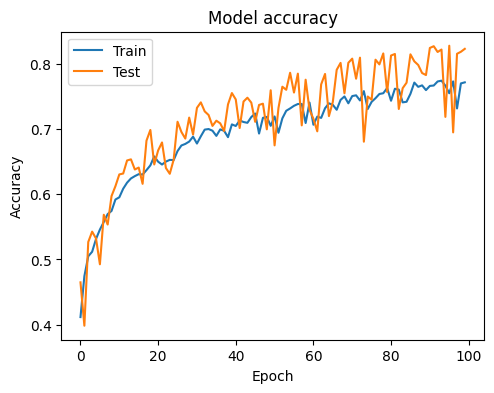

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

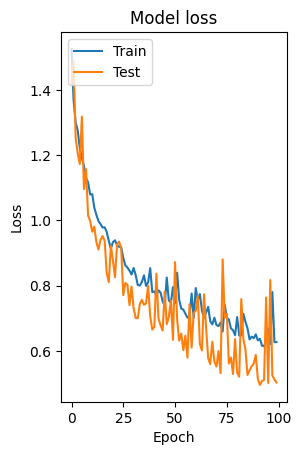

In [17]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [18]:
# Save the model weights
model.save_weights('best_model-EfficientNetB2.h5')